In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer


pd.set_option('display.max_columns', 500)

%matplotlib inline

C:\Users\Omar-Bouj\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Guidelines





 Can we predict success or is it random ?

- dont dive into topic, or content of the course, check predictivity for metadata first
- we can add how many other course treat the same topic ie topic popularity among dataset , for each course


#### course content analysis

- Define how to measure success of a course ? ---> normlaize the total number of subs to each topic

- cluster the course topics: using the tags from  stack overflow we can have the popularity of a topic ? think about how to combine all the tags from a course to GET THE POPUARITY OF THE COURSE not the various popularities from 

- categorize the granularity of the courses : is it about webdev, or a specific tool in webdev ?

- Is it one of the first courses in this topic that are succesfull, or look like an existing one ?
- we can match the tags in the syllabus with tags from StacKoverflow


- is there a patern in appearance of courses in the same topic ? from the first course ever in this topic to the hole bundle of course, course in time analysis

## MetaData analysis :


- success measured by (n subsriber, age, topic)

- might try : dividing subscriber by log of age

- offset by course duration or length, for the same number of subscribers a 40h course is less succesfull than a 2 hour

- calculate a score for a set a successful courses, and say that sucessfulness is attainging 90% of this score.

- correlate the score value with feature of the course : how many lectures when published, how mayny were added, the topic

- check rating of the first month or 3 frst months

- HYPOTHESIS: the first moment a course is published is a major determinant of the success

- plot correlation of score and other ffeatures

- quantify 


### Objective : 
- **Set different ranks**
- **compare them then combine**
- **run regression**

For 21 November :
- We need a succesfull and unsuccesfull set
- Look at the top and bottom 20%s of the ranking
- (Clustering) the courses by topics (granulatrity, ...)
- for  each topic analyze  the feature of most and least succesfull courses.

factor to regresison : 

- size of courses
- nbr of lectures
- creation date
- How long to update a course
- Average size of updates divided by time since last update

 #### Reading preprocessed data

In [2]:
course_details = pd.read_pickle('Preproccessed Data/course_details.pkl')

In [3]:
course_syllabi = pd.read_pickle('Preproccessed Data/course_syllabi.pkl')

In [4]:
course_reviews = pd.read_pickle('Preproccessed Data/course_reviews.pkl')

### Difference in  means between paid and free courses :

- investigating the difference in success between paid and free course :


(only 384/9718, ~4% are free, we should have different criterions of success for paid and free courses )

In [5]:
course_details['is_paid'].value_counts()

True     9333
False     384
Name: is_paid, dtype: int64

We add histogram and boxplot to inspect for tail, maybe there is ONE course that has a lot more subscirbers than the group.

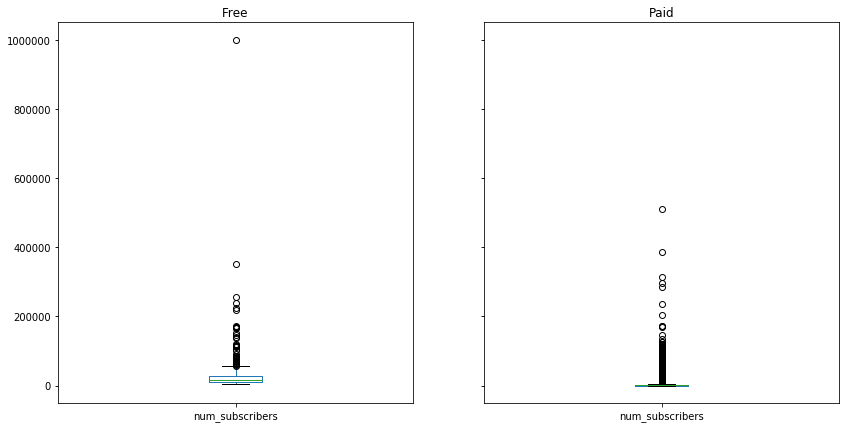

In [6]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(14,7))

# set title
ax[0].set_title('Free')
ax[1].set_title('Paid')


#plot

free = course_details[~course_details['is_paid']].sort_values('num_subscribers',ascending=False)
paid = course_details[ course_details['is_paid']].sort_values('num_subscribers',ascending=False)

free['num_subscribers'].plot.box(ax=ax[0])
paid['num_subscribers'].plot.box(ax=ax[1])

We observe that both distributions of number ofsubscribers for free and paid courses are very skewed. We drop one outlier from free and 2 ouliters from paid

In [7]:
#  outliers to be dropped : one for free courses, 2 for paid courses
outliers_id = pd.concat([free.iloc[[0],:], paid.iloc[:2,:]]).index.tolist()

In [8]:
#course_details.drop(outliers_id,inplace=True)

In [9]:
all_courses  = course_details.mean().rename('All courses')
paid_courses = course_details[course_details['is_paid']].mean().rename('Paid courses')
free_courses = course_details[~course_details['is_paid']].mean().rename('Free courses')

pd.concat([free_courses, paid_courses,all_courses], axis=1)

,Free courses,Paid courses,All courses
avg_rating,4.192206,3.658196,3.679299
avg_rating_recent,4.210535,3.656025,3.677938
is_paid,0.000000,1.000000,0.960482
num_published_lectures,30.984375,52.843459,51.979623
num_published_practice_tests,0.000000,0.012536,0.012041
num_published_quizzes,1.002604,1.242044,1.232582
num_reviews,1535.666667,305.072538,353.703612
num_reviews_recent,163.828125,46.936462,51.555830
num_subscribers,32066.526042,3584.828565,4710.378821
content_length,3.449826,6.269931,6.158485


First, we see the predominance of the paid courses as they represent 96% of this dataset. With this big proportion being paid, we can see the means of the paid group are very close to the means of the full dataset.

We observe that for success factors, free courses are dominating : in terms of total subrscibers, the free courses hit 9 times more subscriber and 5 times more reviews than the paid ones on average.

Conversely, free courses also seems to be less diligent in their content : the content length is doubled for paid courses, with 6h15 of lectures on averages for paid courses against 3h30 for free courses. The number of lectures is also higher for paid courses (+70%) .



In [10]:
# dropping free courses and is_paid column

course_details = course_details[course_details['is_paid']]
course_details.drop('is_paid', axis=1, inplace=True)

# ** Now we only work with paid courses **

### 2. Finding rankings

###### Rank1

In [11]:
# rank by ratings
course_details['Rank by avg_rating'] = course_details['avg_rating'].rank(method='min',ascending=False)

#### Rank2

In [12]:
# rank by num subscribers
course_details['Rank by num_subscribers'] = course_details['num_subscribers'].rank(method='min',ascending=False)

#### Rank 3 and 4

In [25]:
# Creating the column 'age in months'

from datetime import datetime
# change today to when the dataset was scrapped : it was february 2019
course_details['age in days'] = (datetime(2019,2,28) - course_details['published_time']).apply(lambda x : ((x.days)/30)+1)

In [26]:
course_details['avg_r/(age)'] = course_details.apply(lambda row : row['avg_rating']/(row['age in days']), axis=1)

course_details['Rank by avg_r/(age)'] = course_details['avg_r/(age)'].rank(method='min', ascending=False)

In [27]:
course_details['n_subs/(age)'] = course_details.apply(lambda row : row['num_subscribers']/(row['age in days']), axis=1)

course_details['Rank by n_subs/(age)'] = course_details['n_subs/(age)'].rank(method='min',ascending=False)

#### Rank 5 and 6

In [28]:
c1 = 2 #0.0025
c2 = 5 #0.02

In [29]:
# rank by average rating divided by ln(course age in days)
course_details['avg_r/ln(age)'] = course_details.apply(lambda row : row['avg_rating']/np.log(c1*row['age in days']), axis=1)

In [30]:
course_details['Rank by avg_r/ln(age)'] = course_details['avg_r/ln(age)'].rank(method='min',ascending=False)

#course_details.drop('avg_r/ln(age)',axis=1,inplace=True)

course_details['n_subs/ln(age)'] = course_details.apply(lambda row : row['num_subscribers']/np.log(c2*row['age in days']), axis=1)

course_details['Rank by n_subs/ln(age)'] = course_details['n_subs/ln(age)'].rank(method='min',ascending=False)

#course_details.drop('n_subs/ln(age)',axis=1,inplace=True)


###### Comparing the ranks

In [49]:
import seaborn as sns

**One first way to combine the 4 rankings, is to minimize the distance to all 4 ranks :  ==> By Mean of rankings**

We want our output rank to be such that each course rank is at minimal total distance of its input ranks, in this case they are 4, and to be a valid rank

In [60]:
agg_rank = (course_details['Rank by avg_r/(age)']+
             course_details['Rank by avg_r/ln(age)']+
             course_details['Rank by avg_rating']+
             course_details['Rank by n_subs/(age)']+
             course_details['Rank by n_subs/ln(age)']+
             course_details['Rank by num_subscribers'])/6

course_details['Rank aggreg']= agg_rank.rank(method='min',ascending=True)

Plot

In [61]:
ranks_Df = course_details[['Rank by avg_r/(age)','Rank by n_subs/(age)','Rank by avg_rating','Rank by num_subscribers','Rank by avg_r/ln(age)','Rank by n_subs/ln(age)','Rank aggreg']]
corr = ranks_Df.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,Rank by avg_r/(age),Rank by n_subs/(age),Rank by avg_rating,Rank by num_subscribers,Rank by avg_r/ln(age),Rank by n_subs/ln(age),Rank aggreg
Rank by avg_r/(age),1,0.330092,0.472715,0.0791468,0.937804,0.137937,0.619897
Rank by n_subs/(age),0.330092,1,0.348233,0.937995,0.382194,0.963173,0.883665
Rank by avg_rating,0.472715,0.348233,1,0.316874,0.697052,0.326466,0.666868
Rank by num_subscribers,0.0791468,0.937995,0.316874,1,0.166505,0.996393,0.76315
Rank by avg_r/ln(age),0.937804,0.382194,0.697052,0.166505,1,0.218403,0.723729
Rank by n_subs/ln(age),0.137937,0.963173,0.326466,0.996393,0.218403,1,0.799338
Rank aggreg,0.619897,0.883665,0.666868,0.76315,0.723729,0.799338,1


We keep only the **n_subs/ln(age)** rank.

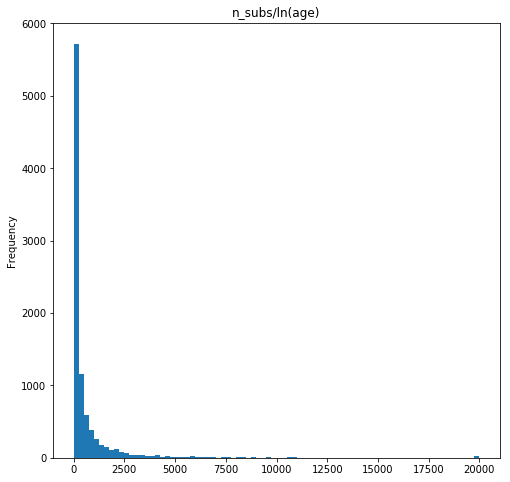

In [67]:
# if n subs/ln is greateter than 20.000, then down to 20.000
course_details['n_subs/ln(age)'] = course_details['n_subs/ln(age)'].apply(lambda x : 20000 if x >20000 else x )
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.set_title('n_subs/ln(age)')
#ax[1].set_title('avg_r/ln(age)')

course_details['n_subs/ln(age)'].sort_values().plot.hist(bins=80, ax=ax)
#course_details['avg_r/ln(age)'].sort_values().plot.hist(bins=80, ax=ax[1])

In [68]:
ser = course_details['n_subs/ln(age)'].apply(lambda x : x>1000)

ser.mean()

0.15986285224472302

We have 16% of the courses that score higher than 1000 at this metric ( n_subs/ln(age) ). We **label them as successfull**

In [69]:
course_details['success'] = ser

##### CourseSyllabi

Let us plot the variety of content and its proportion in the dataset :  

In [ ]:
course_syllabi['content_class'].value_counts().plot.pie(y='content_class', figsize=(7,7))

**What are the biggest courses in term of number of elements ?**

We can see there is a large gap 

In [ ]:
s = course_syllabi['course_id'].value_counts()
s1 = pd.Series(dict((v,k) for k,v in s.iteritems()))

In [ ]:
s.value_counts().plot()

In [ ]:
fig, ax = plt.subplots(1,2, sharey=True)
course_syllabi['course_id'].value_counts().head(15).plot(ax=ax[0], kind='bar', figsize=(14,7))
#ax[1].xaxis.label.set_visible(False)

#course_syllabi['course_id'].value_counts().plot(ax=ax[1],kind='bar', figsize=(14,7))

# todo : show full ditribution in second ax

##### CourseReviews

**Reviews Distribution :** We can see hereunder that **most reviews are positive** with 53% being 5 stars, 85% of reviews are 4 stars or higher :

In [ ]:
fig, ax = plt.subplots()
course_reviews['rating'].value_counts(1).sort_index().plot(ax=ax, kind='bar')

We can compare ratings with text against ratings without : 

**Hypothesis** While mostly favorable reviews are given, in opposition ti bad reviews : a user is more willing to reviews if he has a good opinion about the course. But users who take time to write constructuve reviews tends to be less  appreciative of the course


In [ ]:
fig, ax = plt.subplots(1,2, sharey=True)

# set title
ax[0].set_title('Without Text')
ax[1].set_title('With Text')

# set mean line
ax[0].axhline(course_reviews[ course_reviews['text'].isna()]['rating'].mean())
ax[1].axhline(course_reviews[~course_reviews['text'].isna()]['rating'].mean())

# plot
course_reviews[ course_reviews['text'].isna()]['rating'].value_counts(1).sort_index().plot(ax=ax[0], kind='barh', figsize=(14,7))
course_reviews[~course_reviews['text'].isna()]['rating'].value_counts(1).sort_index().plot(ax=ax[1], kind='barh', figsize=(14,7))


In [ ]:
# Error to stop exec
error

We can study sentiments in textual reviews. 
To do so,  we 'll be using the [Vader model](https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f), which a pretrained NLP model from the [nltk package](https://www.nltk.org/_modules/nltk/sentiment/vader.html) .

In [ ]:
analyser = SentimentIntensityAnalyzer()
course_reviews['positiv']= course_reviews['text'].apply(lambda x : x if x is np.nan else analyser.polarity_scores(x).get('pos'))
course_reviews['neutral']= course_reviews['text'].apply(lambda x : x if x is np.nan else analyser.polarity_scores(x).get('neu'))
course_reviews['negativ']= course_reviews['text'].apply(lambda x : x if x is np.nan else analyser.polarity_scores(x).get('neg'))
course_reviews['compound']= course_reviews['text'].apply(lambda x : x if x is np.nan else analyser.polarity_scores(x).get('compound'))


In [ ]:
course_reviews['sentiment'] = course_reviews.apply(lambda row : np.nan if np.isnan(row['compound']) else ('Neutral' if row['neutral']>.9 else ('Positiv' if row['positiv']>row['negativ'] else 'Negativ')), axis =1)

In [ ]:
course_reviews['sentiment'].value_counts().plot.pie(figsize=(7,7))

**Result**

Looking at the ditribution of commented vs uncommented ratings, we see that both groups have routhly the same distribution and mean.

The sentiment analysis showed that uncommented ratings are largely positive

**The hypothesis stated above appear to be incorrect.**